## Обзор данных

In [50]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import seaborn as sns
import scipy.stats as stats
import math as mth

In [51]:
data = pd.read_csv('/datasets/logs_exp.csv', delimiter='\t')

In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


**Вывод:**
Все названия столбцов необходимо привести к нижнему регистру. Также потребуется измение типов данных в некоторых столбцах.

## Предобработка данных

In [54]:
column_mapping = {
    'EventName': 'event_name',
    'DeviceIDHash': 'device_id_hash',
    'EventTimestamp': 'event_timestamp',
    'ExpId': 'exp_id'
}
data.rename(columns=column_mapping, inplace=True)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [57]:
data.duplicated().sum() #проверяем на количество явных дубликатов

413

In [58]:
data.drop_duplicates(inplace=True)

In [59]:
data.isna().sum()

event_name         0
device_id_hash     0
event_timestamp    0
exp_id             0
dtype: int64

In [60]:
data['event_timestamp'] = pd.to_datetime(data['event_timestamp'], unit='s') 
                                    
                                    #Этот код преобразует 
                                    #столбец event_timestamp из формата timestamp Unix в формат данных datetime. 
                                    #Параметр unit='s' указывает, что значения 
                                    #в столбце интерпретируются как секунды с начала эпохи Unix. 

In [62]:
data['event_date'] = data['event_timestamp'].dt.date
data['event_date'] = pd.to_datetime(data['event_date'])
data['exp_id'] = data['exp_id'].astype(str)

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  object        
 4   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 11.2+ MB


**Вывод:**
- были удалены дубликаты;
- изменины типы данных;
- добавлен столбец с датой;
- пропуски в таблице отсутствуют;
- названия столбцов приведены к нижнему регистру;

## Изучение и проверка данных

In [65]:
total_events = data['event_name'].count()
print("Всего событий в логе:", total_events)

Всего событий в логе: 243713


In [66]:
total_users = data['device_id_hash'].nunique()
print("Всего пользователей в логе:", total_users)

Всего пользователей в логе: 7551


In [67]:
events_per_user = total_events / total_users
print("В среднем событий на пользователя:", events_per_user)
events_per_user_rounded = round(events_per_user, 2)
print("В среднем событий на пользователя (округлено):", events_per_user_rounded)

В среднем событий на пользователя: 32.27559263673685
В среднем событий на пользователя (округлено): 32.28


In [68]:
max_date = data['event_timestamp'].max()
min_date = data['event_timestamp'].min()

print("Максимальная дата:", max_date)
print("Минимальная дата:", min_date)

Максимальная дата: 2019-08-07 21:15:17
Минимальная дата: 2019-07-25 04:43:36


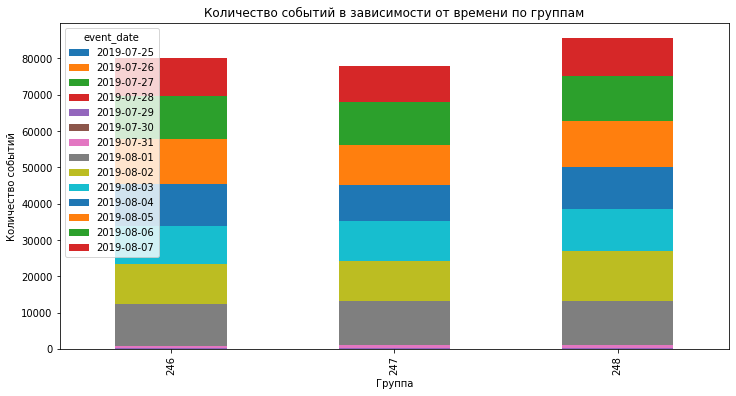

In [69]:
data.groupby(['exp_id', data['event_date'].dt.date])['event_name'].count().unstack().plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Группа')
plt.ylabel('Количество событий')
plt.title('Количество событий в зависимости от времени по группам')
plt.show()

Как мы видим по графику выше у группы 248 показатель общего кол-ва событий наиболее высокий за рассматриваемый период. Кол-во тех или иных событий по разным группам в зависимости от периода имеет относительно схожий удельный вес.

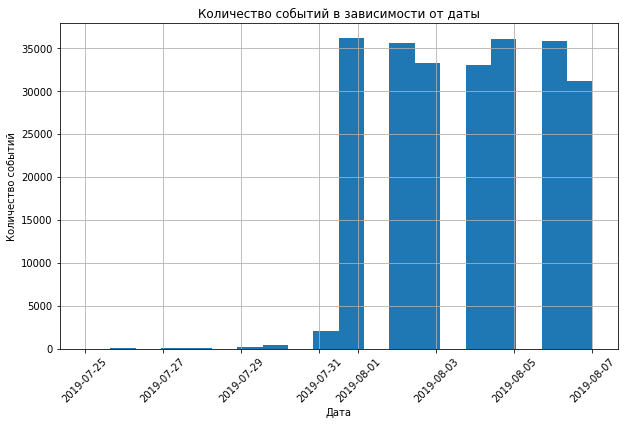

In [70]:
plt.figure(figsize=(10, 6))
data['event_date'].hist(bins=20)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Количество событий в зависимости от даты')
plt.xticks(rotation=45)
plt.show()

До 01.08.2019 видим незначительное количество событий. Отбросим все события до 01.08.2019

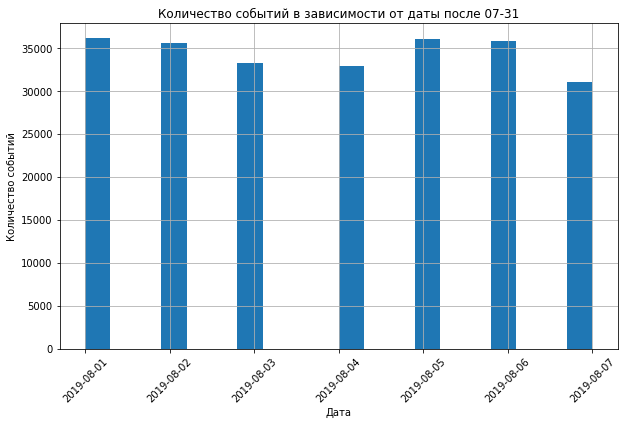

In [71]:
data_new = data.query('event_date>"2019-07-31"')
plt.figure(figsize=(10, 6))
data_new['event_date'].hist(bins=20)
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('Количество событий в зависимости от даты после 07-31')
plt.xticks(rotation=45)
plt.show()

Динамика на графике теперь выглядит более адекватно. Как мы видим наименьшее кол-во событий наблюдается в 2019-08-04, наибольшее 2019-08-05 

In [72]:
data_old = data.query('event_date <= "2019-07-31"')
print("Было потеряно", data_old['event_name'].count(),"событий")

Было потеряно 2826 событий


In [73]:
# Уникальные пользователи до фильтрации
unique_users_original = data['device_id_hash'].nunique()

# Уникальные пользователи после фильтрации
unique_users_after_filter = data[data['event_date'] > '2019-07-31']['device_id_hash'].nunique()

unique_events_original = data['event_name'].count()

# Уникальные события после фильтрации
unique_events_after_filter = data[data['event_date'] > '2019-07-31']['event_name'].count()

In [74]:
# Доля потерь пользователей
user_loss_percentage = ((unique_users_original - unique_users_after_filter) / unique_users_original) * 100

# Доля потерь событий
event_loss_percentage = ((unique_events_original - unique_events_after_filter) / unique_events_original) * 100

print("Доля потерь пользователей:", round(user_loss_percentage, 2), "%")
print("Доля потерь событий:", round(event_loss_percentage,2), "%")


Доля потерь пользователей: 0.23 %
Доля потерь событий: 1.16 %


In [75]:
data_new['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

Видно, что от 7-8к событий приходится на каждую группу.

**Вывод:**
- Всего событий в логе: 243713;
- Всего пользователей в логе: 7551;
- В среднем событий на пользователя (округлено): 32.28;
- Максимальная дата: 2019-08-07 21:15:17;
- Минимальная дата: 2019-07-25 04:43:36;
- У группы 248 показатель общего кол-ва событий наиболее высокий за рассматриваемый период. Кол-во тех или иных событий по разным группам в зависимости от периода имеет относительно схожий удельный вес.
- До 01.08.2019 видим незначительное количество событий. Отбросим все события до 01.08.2019;
- Наименьшее кол-во событий наблюдается в 2019-08-04, наибольшее 2019-08-05;
- После фильтрации было потеряно 2826 событий;
- Доля потерь пользователей: 0.23 %
- Доля потерь событий: 1.16 %
- Видно, что от 7-8к событий приходится на каждую группу.


## Изучение воронки событий

In [76]:
events_counts = data['event_name'].value_counts()

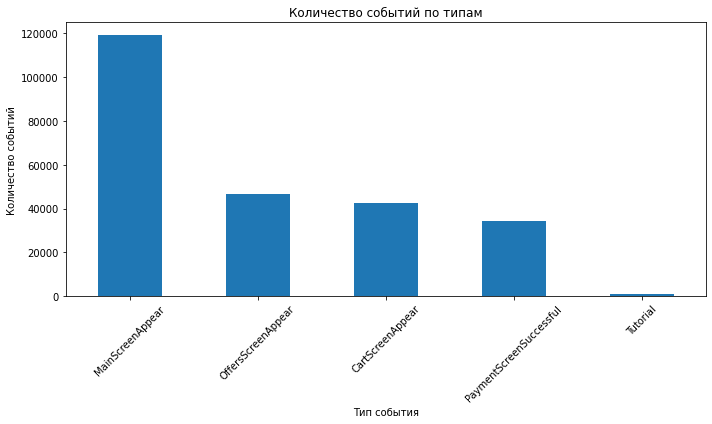

In [77]:
plt.figure(figsize=(10, 6))
events_counts.plot(kind='bar')
plt.title('Количество событий по типам')
plt.xlabel('Тип события')
plt.ylabel('Количество событий')
plt.xticks(rotation=45)  # Поворачиваем метки по оси X для лучшей читаемости

plt.tight_layout()
plt.show()

На графике 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения

In [78]:
event_users_count = data.groupby('event_name')['device_id_hash'].nunique().reset_index()
event_users_count.columns = ['event_name', 'user_count']

event_users_count = event_users_count.sort_values(by='user_count', ascending=False)
total_unique_users = data['device_id_hash'].nunique()


event_users_count['user_percentage'] = event_users_count['user_count'] / total_unique_users * 100

event_users_count


,event_name,user_count,user_percentage
1,MainScreenAppear,7439,98.516753
2,OffersScreenAppear,4613,61.091246
0,CartScreenAppear,3749,49.649053
3,PaymentScreenSuccessful,3547,46.973911
4,Tutorial,847,11.217057


Рассматриваемые события складываются в воронку продаж. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты

Порядок, в котором происходят события, может зависеть от специфики приложения и целей анализа. Однако, обычно события в анализе данных о пользовательском взаимодействии с приложением выстраиваются в логическую последовательную цепочку, которая отражает типичный путь пользователя.  

Например, типичная последовательность событий в электронной коммерции может выглядеть так:  

1. MainScreenAppear (Главный экран появляется) - Это событие, возможно, означает, что пользователь открыл приложение.

2. OffersScreenAppear (Появление страницы предложений) - После открытия главного экрана, пользователь переходит на страницу с предложениями.

3. CartScreenAppear (Появление страницы корзины) - Пользователь добавляет товары в корзину.

4. PaymentScreenSuccessful (Успешное совершение оплаты) - Пользователь завершает покупку и совершает успешную оплату.

5. Tutorial (Обучение) - Это может быть опциональным событием, где новые пользователи проходят обучение перед основным взаимодействием с приложением.  

Однако не все события обязательно входят в воронку. Например, событие "Tutorial" может быть информационным и не влиять на воронку конверсии.

In [79]:
# Создаем список событий в порядке воронки
events_in_funnel = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']

# Создаем DataFrame для хранения результатов
funnel_conversion = pd.DataFrame(columns=['Event', 'Users', 'Conversion'])

# Пройдем по событиям в порядке воронки и рассчитаем долю пользователей
for i in range(1, len(events_in_funnel)):
    event_A = events_in_funnel[i - 1]
    event_B = events_in_funnel[i]
    
    users_A = event_users_count[event_users_count['event_name'] == event_A]['user_count'].values[0]
    users_B = event_users_count[event_users_count['event_name'] == event_B]['user_count'].values[0]
    
    conversion = (users_B / users_A) * 100 if users_A > 0 else 0
    
    funnel_conversion = funnel_conversion.append({'Event': event_B, 'Users': users_B, 'Conversion': conversion}, ignore_index=True)

funnel_conversion


,Event,Users,Conversion
0,OffersScreenAppear,4613,62.011023
1,CartScreenAppear,3749,81.270323
2,PaymentScreenSuccessful,3547,94.611897


- На экран с предложением проходит 62% пользователей, посмотревших главный экран.
- На экран с корзиной переходит 81% пользователей.
- На экран с успешной оплатой переходит 95% пользователей.

Важно понять на каком шаге мы теряем больше всего пользователей.
- К экрану с предложением проходит только 62% пользователей.
Наименее популярным событием в воронке продаж,как и следовало ожидать,является событие перехода к оплате. Но если смотреть на конверсию, то большой процент пользователей теряется при переходе от главного экрана к самому экрану с предложением.

In [80]:
# Количество уникальных пользователей, совершивших первое событие (MainScreenAppear)
users_main_screen = event_users_count[event_users_count['event_name'] == 'MainScreenAppear']['user_count'].values[0]

# количество уникальных пользователей, совершивших оплату (PaymentScreenSuccessful)
users_payment_successful = event_users_count[event_users_count['event_name'] == 'PaymentScreenSuccessful']['user_count'].values[0]

# Доля пользователей, совершивших оплату относительно тех, кто начал с первого события
conversion_to_payment = (users_payment_successful / users_main_screen) * 100 if users_main_screen > 0 else 0
print(f"Доля пользователей, дошедших от первого события до оплаты: {conversion_to_payment:.2f}%")


Доля пользователей, дошедших от первого события до оплаты: 47.68%


**Вывод:**
- На графике 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения;
- Рассматриваемые события складываются в воронку продаж. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты;
- На экран с предложением проходит 62% пользователей, посмотревших главный экран.
- На экран с корзиной переходит 81% пользователей.
- На экран с успешной оплатой переходит 95% пользователей.
- К экрану с предложением проходит только 62% пользователей.
Наименее популярным событием в воронке продаж,как и следовало ожидать,является событие перехода к оплате. Но если смотреть на конверсию, то большой процент пользователей теряется при переходе от главного экрана к самому экрану с предложением.
- Доля пользователей, дошедших от первого события до оплаты: 47.68%

## Изучение результатов эксперимента

In [81]:
users_per_group = data.groupby('exp_id')['device_id_hash'].nunique()

users_per_group

exp_id
246    2489
247    2520
248    2542
Name: device_id_hash, dtype: int64

В 246 группе 2484 пользователя, в 247 группе 2513 пользователей, в группе 248, с увеличенными шрифтами, 2537 пользователей.

In [82]:
users_per_group = data.groupby('exp_id')['device_id_hash'].nunique()
users_in_multiple_groups = data.groupby('device_id_hash')['exp_id'].nunique() > 1

if users_in_multiple_groups.any():
    print("Внимание! Некоторые пользователи принадлежат более чем одной группе:")
    print(data[data['device_id_hash'].isin(users_in_multiple_groups.index)][['device_id_hash', 'exp_id']])

print("Количество уникальных пользователей в каждой группе:")
print(users_per_group)


Количество уникальных пользователей в каждой группе:
exp_id
246    2489
247    2520
248    2542
Name: device_id_hash, dtype: int64


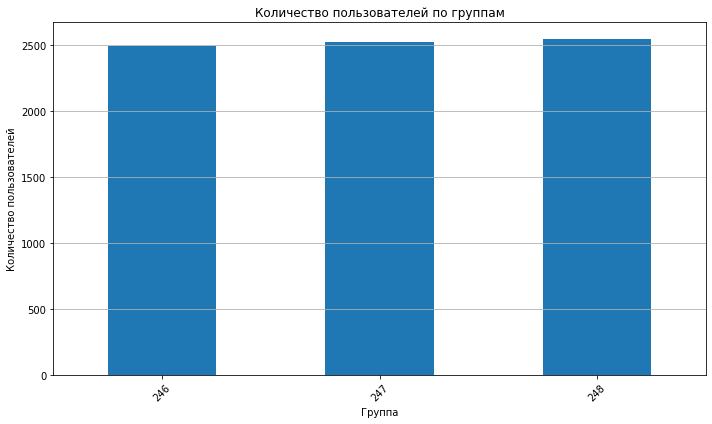

In [83]:
plt.figure(figsize=(10, 6))
users_per_group.plot(kind='bar')
plt.title('Количество пользователей по грyппам')
plt.xlabel('Группа')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=45)  # Поворачиваем метки по оси X для лучшей читаемости

plt.tight_layout()
plt.grid(True, axis='y') 
plt.show()

График показывает, что кол-во пользователей по группам плюс минус одинаковое.

In [84]:
# Создаем сводную таблицу с числом уникальных пользователей по событиям и группам
voronka = data_new.pivot_table(
    index='event_name',
    columns='exp_id',
    values='device_id_hash',
    aggfunc='nunique'
)

# Удаляем столбец 'Tutorial', если он присутствует
if 'Tutorial' in voronka.index:
    voronka = voronka.drop('Tutorial')

# Добавляем столбец с общим числом пользователей в каждой группе
voronka.loc['Total'] = data_new.groupby('exp_id')['device_id_hash'].nunique()
voronka = voronka.T
voronka


event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537


In [85]:
# Напишем функцию для проверки гипотез
def hypothesis (success, trials, alpha):
    p1 = success[0] / trials[0]
    p2 = success[1] / trials[1]
    p_combined = (success[0] + success[1]) / (trials[0] + trials[1])
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_combined *(1-p_combined) * (1/trials[0] + 1/trials[1]))
    distr = stats.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value, end='')
    if (p_value < alpha):
        print(" Отвергаем нулевую гипотезу: между долями есть значимая разница")
        print('')
    else:
        print(" Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')

In [86]:
def automation(group1, group2, alpha):
    events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
    
    for event in events:
        success = [voronka[event][group1], voronka[event][group2]]
        trials = [voronka['Total'][group1], voronka['Total'][group2]]
        
        print(f'Результаты теста по долям {event} для групп')
        hypothesis(success, trials, alpha)

H_0: Доля в выборке А1 = Доля в выборке А2

H_1: Доля в выборке А1 != Доля в выборке А2

alpha = 0.1

In [87]:
# проверка групп А1/А2
automation (0, 1, 0.1)

Результаты теста по долям MainScreenAppear для групп
p-значение:  0.7570597232046099 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear для групп
p-значение:  0.2480954578522181 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям CartScreenAppear для групп
p-значение:  0.22883372237997213 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful для групп
p-значение:  0.11456679313141849 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:**
- Нет оснований считать контрольные выборки групп 246 и 247 разными. Контрольные группы выбраны верны. 
- Показ главного экрана сайта - самое популярное событие. С этого и начинается воронка продаж.

In [88]:
#Соединим две контрольные группы в группу 249
voronka.loc['249'] = [voronka['CartScreenAppear'][0]+voronka['CartScreenAppear'][1] , voronka['MainScreenAppear'][0]+voronka['MainScreenAppear'][1], voronka['OffersScreenAppear'][0]+voronka['OffersScreenAppear'][1], voronka['PaymentScreenSuccessful'][0]+voronka['PaymentScreenSuccessful'][1], voronka['Total'][0]+voronka['Total'][1]]
voronka

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Total
exp_id,,,,,
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
248,1230,2493,1531,1181,2537
249,2504,4926,3062,2358,4997


H_0: Доля в выборке А1 = Доля в выборке В

H_1: Доля в выборке А1 != Доля в выборке В

alpha = 0.1

In [89]:
automation (0, 2, 0.1)

Результаты теста по долям MainScreenAppear для групп
p-значение:  0.2949721933554552 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear для групп
p-значение:  0.20836205402738917 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям CartScreenAppear для групп
p-значение:  0.07842923237520116 Отвергаем нулевую гипотезу: между долями есть значимая разница

Результаты теста по долям PaymentScreenSuccessful для групп
p-значение:  0.2122553275697796 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



In [90]:
print('В 246-ой контрольной группе', round(voronka['CartScreenAppear'].iloc[0]/voronka['Total'].iloc[1], 2)*100, '% пользователей переходит к оплате')
print('В 248-ой группе', round(voronka['CartScreenAppear'].iloc[2]/voronka['Total'].iloc[2], 2)*100, '% пользователей переходит к оплате')

В 246-ой контрольной группе 50.0 % пользователей переходит к оплате
В 248-ой группе 48.0 % пользователей переходит к оплате


H_0: Доля в выборке А2 = Доля в выборке В

H_1: Доля в выборке А2 != Доля в выборке В

alpha = 0.1

In [91]:
automation (1, 2, 0.1)

Результаты теста по долям MainScreenAppear для групп
p-значение:  0.4587053616621515 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear для групп
p-значение:  0.9197817830592261 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям CartScreenAppear для групп
p-значение:  0.5786197879539783 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful для групп
p-значение:  0.7373415053803964 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



H_0: Доля в выборке А = Доля в выборке В

H_1: Доля в выборке А != Доля в выборке В

alpha = 0.1

In [92]:
# проверка групп А/В (249 и 248)
automation (3, 2, 0.1)

Результаты теста по долям MainScreenAppear для групп
p-значение:  0.29424526837179577 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear для групп
p-значение:  0.43425549655188256 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям CartScreenAppear для групп
p-значение:  0.18175875284404386 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful для групп
p-значение:  0.6004294282308704 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод:**   
- Между группой А1 (246) и группой В (248) значимых различий нет.  
- Между ггруппой А2 (247) и группой В (248) есть значимая разница в доле пользоватей, перешедших к странице корзины (48% у группы В против 50% у группы А2).
- Между объединенной группой А (249) и группой В (248) значимых различий нет.  

### Проверка гипотез при уровне стат.значимости 0.05

H_0: Доля в выборке А1 = Доля в выборке А2

H_1: Доля в выборке А1 != Доля в выборке А2

alpha = 0.05

In [93]:
automation (0, 1, 0.05)

Результаты теста по долям MainScreenAppear для групп
p-значение:  0.7570597232046099 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear для групп
p-значение:  0.2480954578522181 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям CartScreenAppear для групп
p-значение:  0.22883372237997213 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful для групп
p-значение:  0.11456679313141849 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



H_0: Доля в выборке А1 = Доля в выборке В

H_1: Доля в выборке А1 != Доля в выборке В

alpha = 0.05

In [94]:
automation (0, 2, 0.05)

Результаты теста по долям MainScreenAppear для групп
p-значение:  0.2949721933554552 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear для групп
p-значение:  0.20836205402738917 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям CartScreenAppear для групп
p-значение:  0.07842923237520116 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful для групп
p-значение:  0.2122553275697796 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



H_0: Доля в выборке А2 = Доля в выборке В

H_1: Доля в выборке А2 != Доля в выборке В

alpha = 0.05

In [95]:
automation (1, 2, 0.05)

Результаты теста по долям MainScreenAppear для групп
p-значение:  0.4587053616621515 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear для групп
p-значение:  0.9197817830592261 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям CartScreenAppear для групп
p-значение:  0.5786197879539783 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful для групп
p-значение:  0.7373415053803964 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



H_0: Доля в выборке А = Доля в выборке В

H_1: Доля в выборке А != Доля в выборке В

alpha = 0.05

In [96]:
automation (3, 2, 0.05)

Результаты теста по долям MainScreenAppear для групп
p-значение:  0.29424526837179577 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям OffersScreenAppear для групп
p-значение:  0.43425549655188256 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям CartScreenAppear для групп
p-значение:  0.18175875284404386 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Результаты теста по долям PaymentScreenSuccessful для групп
p-значение:  0.6004294282308704 Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Вывод**: При измепнении уровня значимости на 0.05 доли во всех выборках равны. Различий между контрольными группами и тестовой нет.

**Вывод:**
- В 246 группе 2484 пользователя, в 247 группе 2513 пользователей, в группе 248, с увеличенными шрифтами, 2537 пользователей.
- Нет оснований считать контрольные выборки групп 246 и 247 разными. Контрольные группы выбраны верны.
- Показ главного экрана сайта - самое популярное событие. С этого и начинается воронка продаж.
- Между группой А1 (246) и группой В (248) значимых различий нет.
Между ггруппой А2 (247) и группой В (248) есть значимая разница в доле пользоватей, перешедших к странице корзины (48% у группы В против 50% у группы А2).
Между объединенной группой А (249) и группой В (248) значимых различий нет.
-  При измепнении уровня значимости на 0.05 доли во всех выборках равны. Различий между контрольными группами и тестовой нет.

## Вывод

- Все названия столбцов необходимо привести к нижнему регистру. Также потребуется измение типов данных в некоторых столбцах.
- В рамках предобработки данных были удалены дубликаты; изменины типы данных; добавлен столбец с датой; пропуски в таблице отсутствуют; названия столбцов приведены к нижнему регистру;
- Всего событий в логе: 243713;
- Всего пользователей в логе: 7551;
- В среднем событий на пользователя (округлено): 32.28;
- Максимальная дата: 2019-08-07;
- Минимальная дата: 2019-07-25;
- У группы 248 показатель общего кол-ва событий наиболее высокий за рассматриваемый период. Кол-во тех или иных событий по разным группам в зависимости от периода имеет относительно схожий удельный вес.
- До 01.08.2019 видим незначительное количество событий. Отбросим все события до 01.08.2019;
- Наименьшее кол-во событий наблюдается в 2019-08-04, наибольшее 2019-08-05;
- После фильтрации было потеряно 2826 событий;
- Доля потерь пользователей: 0.23 %
- Доля потерь событий: 1.16 %
- От 7-8к событий приходится на каждую группу.
- На графике 5 событий, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения;
- Рассматриваемые события складываются в воронку продаж. Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты;
- На экран с предложением проходит 62% пользователей, посмотревших главный экран.
- На экран с корзиной переходит 81% пользователей.
- На экран с успешной оплатой переходит 95% пользователей.
- К экрану с предложением проходит только 62% пользователей. Наименее популярным событием в воронке продаж,как и следовало ожидать,является событие перехода к оплате. Но если смотреть на конверсию, то большой процент пользователей теряется при переходе от главного экрана к самому экрану с предложением.
- Доля пользователей, дошедших от первого события до оплаты: 47.68%;
- В 246 группе 2484 пользователя, в 247 группе 2513 пользователей, в группе 248, с увеличенными шрифтами, 2537 пользователей.
- Нет оснований считать контрольные выборки групп 246 и 247 разными. Контрольные группы выбраны верны.
- Показ главного экрана сайта - самое популярное событие. С этого и начинается воронка продаж.
- Между группой А1 (246) и группой В (248) значимых различий нет. Между ггруппой А2 (247) и группой В (248) есть значимая разница в доле пользоватей, перешедших к странице корзины (48% у группы В против 50% у группы А2). Между объединенной группой А (249) и группой В (248) значимых различий нет.
- При измепнении уровня значимости на 0.05 доли во всех выборках равны. Различий между контрольными группами и тестовой нет.

**По результатам анализа можно сделать вывод:** дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно - в этом случае менеджеры были правы, шрифты менять не нужно.